# Imports #

## Libraries ##

In [1]:
import pandas as pd
import numpy as np
import itertools
from scipy import linalg
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib import offsetbox
from matplotlib.ticker import NullFormatter
import seaborn as sns
from time import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.cluster import KMeans, DBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, homogeneity_score, \
completeness_score, adjusted_rand_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Fonctions for later ##

Coming from the GitHub of Ritchieng.

In [2]:
# Fonctioms from Ritchieng from GitHub

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar', color=list(mcolors.CSS4_COLORS));
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = plt.cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

## Dataset ##

In [3]:
data_df = pd.read_csv('Ressources' + '/' + 'Data.csv')
segmented_data_df = pd.read_csv('Ressources' + '/' + 'SegmentedData.csv')

data_df.dropna(subset=['customer_unique_id'], inplace=True)
data_df.reset_index(drop=True, inplace=True)
data_df.drop(columns=['review_comment_message'], inplace=True)

data_df

,customer_unique_id,customer_state,customer_city,zip_code,geolocation_lat,geolocation_lng,order_id,order_status,seller_id,seller_state,...,order_item_id,product_id,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,861eff4711a542e4b93843c6dd7febb0,SP,franca,14409,-20.509898,-47.397866,00e7ee1b050b8499577073aeb2a297a1,delivered,7c67e1448b00f6e969d365cea6b010ab,SP,...,1,a9516a079e37a9c9c36b9b78b10169e8,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,452fab1c62b178922fc011b0eb89c1b9,BA,barreiras,47800,-12.147031,-44.996092,a4866dfc455353f48014a2b9a86608a2,delivered,7c67e1448b00f6e969d365cea6b010ab,SP,...,1,a9516a079e37a9c9c36b9b78b10169e8,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,452fab1c62b178922fc011b0eb89c1b9,BA,barreiras,47800,-12.147031,-44.996092,a4866dfc455353f48014a2b9a86608a2,delivered,7c67e1448b00f6e969d365cea6b010ab,SP,...,2,a9516a079e37a9c9c36b9b78b10169e8,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,613259d64ba972e49dc25b019b7918c3,SP,barueri,6414,-23.495901,-46.874687,03afb3c10af52ddfa3c33b9881bf43f8,delivered,7c67e1448b00f6e969d365cea6b010ab,SP,...,1,a9516a079e37a9c9c36b9b78b10169e8,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,aaad33c5051196b5e73c7d65b9072e1d,MG,alfenas,37137,-21.407289,-45.940358,3c75044db750a89606612ed286713eb8,delivered,7c67e1448b00f6e969d365cea6b010ab,SP,...,1,a9516a079e37a9c9c36b9b78b10169e8,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116002,e4469e5047c00b0188885853d357d2ab,SP,sao paulo,4116,-23.590958,-46.629899,cb53f0b6e8f9082a9f5a113765dd1236,delivered,dbb9b48c841a0e39e21f98e1a6b2ec3e,SP,...,1,8cfc3506cedc0626364457d254429118,fashion_childrens_clothes,47.0,327.0,3.0,300.0,30.0,20.0,20.0
116003,27558f96bc671d0594c60be61566aeb4,BA,macaubas,46500,-13.020058,-42.693509,cab08f0417a702d0f4782ec02356a4ac,delivered,dbb9b48c841a0e39e21f98e1a6b2ec3e,SP,...,1,8cfc3506cedc0626364457d254429118,fashion_childrens_clothes,47.0,327.0,3.0,300.0,30.0,20.0,20.0
116004,1b553902a5bbe6ee54a3aaa7cbfb6816,RJ,nova iguacu,26255,-22.761992,-43.450873,ee86b68eb9222b0cad7da50f4f758a35,delivered,28ea411b354f14b1a494be4e79f0ce02,SP,...,1,0ab3ab3b2869073aa9afe795fe9151aa,fashion_childrens_clothes,52.0,494.0,4.0,600.0,36.0,10.0,26.0
116005,1f83c87997168e248ea52ad3453b069f,SP,sao paulo,4128,-23.602765,-46.635308,3da4b0f0c89bb8fee8a810459e641414,delivered,28ea411b354f14b1a494be4e79f0ce02,SP,...,1,28ac6af4008a402e5039f3e042a36e13,fashion_childrens_clothes,48.0,488.0,5.0,500.0,36.0,10.0,26.0


# Preprocessing the Data #

## Basic Informations ##

In [4]:
# Dataset Informations
print("Dataset's size : {}\n\nColumns' Names\n{}"
      .format(np.shape(data_df),[k for l,k in enumerate(data_df.columns)]))

Dataset's size : (116007, 81)

Columns' Names
['customer_unique_id', 'customer_state', 'customer_city', 'zip_code', 'geolocation_lat', 'geolocation_lng', 'order_id', 'order_status', 'seller_id', 'seller_state', 'seller_city', 'seller_zip_code', 'seller_lat', 'seller_lng', 'price', 'freight_value', 'payment_value', 'payment_type', 'payment_installments', 'payment_sequential', 'review_id', 'review_score', 'review_comment_title', 'review_creation_date_year', 'review_creation_date_month', 'review_creation_date_day', 'review_creation_date_weekday_name', 'review_creation_date_hour', 'review_creation_date_minute', 'review_answer_timestamp_year', 'review_answer_timestamp_month', 'review_answer_timestamp_day', 'review_answer_timestamp_weekday_name', 'review_answer_timestamp_hour', 'review_answer_timestamp_minute', 'order_purchase_timestamp_year', 'order_purchase_timestamp_month', 'order_purchase_timestamp_day', 'order_purchase_timestamp_weekday_name', 'order_purchase_timestamp_hour', 'order_pur

## Initializing Variables ##

In [5]:
numerical_columns = ['geolocation_lat',
                     'geolocation_lng',
                     'seller_lat',
                     'seller_lng',
                     'price',
                     'freight_value',
                     'payment_value',
                     'payment_installments',
                     'payment_sequential',
                     'review_creation_date_year',
                     'review_creation_date_month',
                     'review_creation_date_day',
                     'review_creation_date_hour',
                     'review_creation_date_minute',
                     'review_answer_timestamp_year',
                     'review_answer_timestamp_month',
                     'review_answer_timestamp_day',
                     'review_answer_timestamp_hour',
                     'review_answer_timestamp_minute',
                     'order_purchase_timestamp_year',
                     'order_purchase_timestamp_month',
                     'order_purchase_timestamp_day',
                     'order_purchase_timestamp_hour',
                     'order_purchase_timestamp_minute',
                     'order_approved_at_year',
                     'order_approved_at_month',
                     'order_approved_at_day',
                     'order_approved_at_hour',
                     'order_approved_at_minute',
                     'order_delivered_carrier_date_year',
                     'order_delivered_carrier_date_month',
                     'order_delivered_carrier_date_day',
                     'order_delivered_carrier_date_hour',
                     'order_delivered_carrier_date_minute',
                     'order_delivered_customer_date_year',
                     'order_delivered_customer_date_month',
                     'order_delivered_customer_date_day',
                     'order_delivered_customer_date_hour',
                     'order_delivered_customer_date_minute',
                     'order_estimated_delivery_date_year',
                     'order_estimated_delivery_date_month',
                     'order_estimated_delivery_date_day',
                     'order_estimated_delivery_date_hour',
                     'order_estimated_delivery_date_minute',
                     'shipping_limit_date_year',
                     'shipping_limit_date_month',
                     'shipping_limit_date_day',
                     'shipping_limit_date_hour',
                     'shipping_limit_date_minute',
                     'product_name_lenght',
                     'product_description_lenght',
                     'product_photos_qty',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm'
                    ]

categorical_columns = ['customer_state',
                       'customer_city',
                       'zip_code',
                       'order_id',
                       'order_status',
                       'seller_id',
                       'seller_state',
                       'seller_city',
                       'seller_zip_code',
                       'payment_type',
                       'review_id',
                       'review_score',
                       'review_comment_title',
                       'review_creation_date_weekday_name',
                       'review_answer_timestamp_weekday_name',
                       'order_purchase_timestamp_weekday_name',
                       'order_approved_at_weekday_name',
                       'order_delivered_carrier_date_weekday_name',
                       'order_delivered_customer_date_weekday_name',
                       'order_estimated_delivery_date_weekday_name',
                       'shipping_limit_date_weekday_name',
                       'order_item_id',
                       'product_id',
                       'product_category_name_english',
                       'customer_unique_id'
                       ]

In [9]:
segmented_numerical_columns = ['average_distance_from_sellers',
                               'average_freight_value', 'average_volume_of_product',
                               'average_weight_of_product', 'orders_number', 
                               'products_number','total_payment', 'percent_of_shop_income'
                               ]

segmented_categorical_columns = ['customer_city', 'last_purchase_trimester',
                                 'usual_weekday_of_purchase', 'usual_hour_of_purchase', 
                                 'average_review_score', 'usual_payment_type'
                                 ]


## Pipelines ##

We will first define some pipelines used for the preprocessing. Here, we will transform the strings in numbers and rescale the numerical variables.

In [8]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
    #('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', RobustScaler(with_centering=False))
    ])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', RobustScaler())
    ])

#ID_pipe = Pipeline([
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
#    #('encoder', OneHotEncoder(handle_unknown='ignore')),
#    ('scaler', RobustScaler(with_centering=False))
#    ])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns),
#     ('ID', ID_pipe, ['customer_unique_id'])
    ])

In [10]:
segmented_categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
    #('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', RobustScaler(with_centering=False))
    ])

segmented_numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', RobustScaler())
    ])

segmented_ID_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
    #('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', RobustScaler(with_centering=False))
    ])

segmented_preprocessing = ColumnTransformer(
    [('cat', segmented_categorical_pipe, segmented_categorical_columns),
     ('num', segmented_numerical_pipe, segmented_numerical_columns),
     ('ID', segmented_ID_pipe, ['customer_id'])
    ])

## Preprocessing in itself ##

In [11]:
X = data_df
X = preprocessing.fit_transform(X)

In [12]:
segmented_X = segmented_data_df
segmented_X = segmented_preprocessing.fit_transform(segmented_X)

# All the data #

## Reducing the Data ##

We will now look into reducing the data to be able to visualise it and to simplify the segmentation. We will try several methods of reduction to see what work the best.

### PCA ###

We will first try with a PCA since it is one of the most common dimension reduction tool.

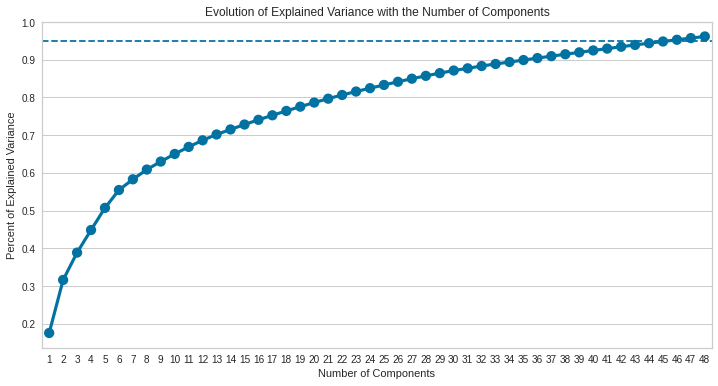

In [25]:
pca_df = pd.DataFrame(columns=['components_number', 'explained_variance'])

for i in range(1,49):
    pca_df.loc[i-1, 'components_number'] = i
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    pca_df.loc[i-1, 'explained_variance'] = pca.explained_variance_ratio_.sum()

f, ax = plt.subplots(figsize=(12,6))

sns.pointplot(x='components_number', 
              y='explained_variance', 
              data=pca_df, 
              markers=['o'], 
              linestyles=['-'])

plt.axhline(y=0.95, linestyle='--')

plt.title('Evolution of Explained Variance with the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Explained Variance')
plt.show()

In [26]:
pca = PCA(n_components=48)
X_pca = pca.fit_transform(X)

print('Percentage of variance explained by each component : \n{}\n'.format(pca.explained_variance_ratio_))
print('Sum of it:\n{}'.format(pca.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[0.17548414 0.14059782 0.07252408 0.05981937 0.058666   0.0473584
 0.02842254 0.02587134 0.02126359 0.02011084 0.01871697 0.0176116
 0.01540272 0.01334931 0.01301574 0.01265572 0.0119829  0.01150406
 0.01133734 0.01087928 0.01033325 0.0098425  0.00918105 0.00879926
 0.00852576 0.00845435 0.00819381 0.00749134 0.00732556 0.00677249
 0.00610441 0.00591262 0.00566282 0.00531437 0.00509334 0.00508163
 0.0050173  0.00501132 0.00499564 0.00496955 0.00492882 0.00492044
 0.00467587 0.0046251  0.00454138 0.00446493 0.00441931 0.0043102 ]

Sum of it:
0.9615421911178228


In [27]:
all_pca_results = pca_results(data_df, pca)

ValueError: Shape of passed values is (48, 80), indices imply (48, 81)

### SVD ###

We will first try with a SVD since it is one of the most common dimension reduction tool and our dataset is sparse (PCA doesn't work in that case).

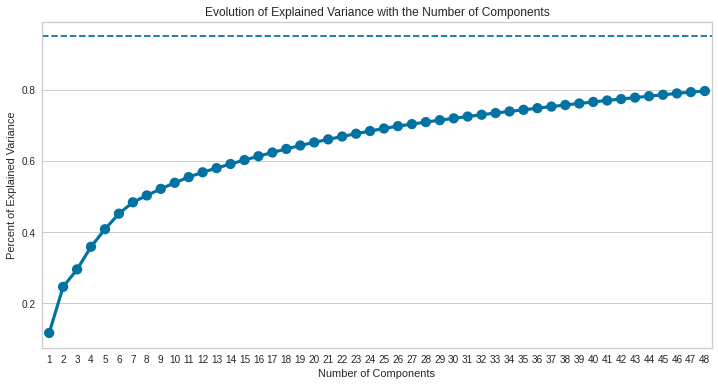

In [55]:
svd_df = pd.DataFrame(columns=['components_number', 'explained_variance'])

for i in range(1,49):
    svd_df.loc[i-1, 'components_number'] = i
    svd = TruncatedSVD(n_components=i)
    X_pca = svd.fit_transform(X)
    svd_df.loc[i-1, 'explained_variance'] = svd.explained_variance_ratio_.sum()

f, ax = plt.subplots(figsize=(12,6))

sns.pointplot(x='components_number', 
              y='explained_variance', 
              data=svd_df, 
              markers=['o'], 
              linestyles=['-'])

plt.axhline(y=0.95, linestyle='--')

plt.title('Evolution of Explained Variance with the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Explained Variance')
plt.show()

As we can see, we still need a lot of components to explained the dataset. We cannot simplify it too much.

We will keep 46 components to have at least 95% of variance explained .

In [56]:
svd = TruncatedSVD(n_components=112)
X_svd = svd.fit_transform(X)

print('Percentage of variance explained by each component : \n{}\n'.format(svd.explained_variance_ratio_))
print('Sum of it:\n{}'.format(svd.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[0.11621152 0.12958393 0.04915412 0.06373707 0.04932155 0.04371909
 0.03189276 0.01935669 0.01845428 0.01715125 0.01591484 0.01360527
 0.01177164 0.01159988 0.01101584 0.01092146 0.01037737 0.00997856
 0.00972232 0.008693   0.00853081 0.0079978  0.00785621 0.00766933
 0.00705208 0.00670348 0.00570979 0.00566061 0.0054902  0.00516332
 0.0050817  0.00498563 0.00489665 0.00460369 0.00452182 0.00448571
 0.00444164 0.00440323 0.00425852 0.00421828 0.00417903 0.00408512
 0.00401215 0.00396322 0.00393014 0.00387009 0.00367328 0.0030043
 0.00298319 0.00276513 0.00273697 0.00268921 0.00267199 0.00262111
 0.00253835 0.00233565 0.00225326 0.00215302 0.00209456 0.00206068
 0.00203889 0.00199213 0.00194015 0.00187279 0.00184481 0.00183382
 0.00180916 0.00174396 0.00169154 0.00167098 0.00162691 0.00156849
 0.00156185 0.00151117 0.0013338  0.00130763 0.00128059 0.00125902
 0.00121905 0.00118111 0.00108959 0.00107155 0.00103721 0.00103243
 0.000986

### MDS and Isomap ###

We tried these method of reduction as well but our dataset was too big and too much RAM was needed for the computer to handle.

### t-SNE ###

In [20]:
tsne = TSNE(n_components=2, perplexity=300, n_iter=600, init='pca')
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
colour = np.random.randint(1, 5, size=len(X_tsne))

ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colour ,cmap=plt.cm.Spectral)
ax.set_title('Method TSNE, time taken : {} s'.format(t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.show()

## Testing Differents Unspervised Algorithms ##

### K-Means ###

#### Testing ####

##### Without the PCA #####

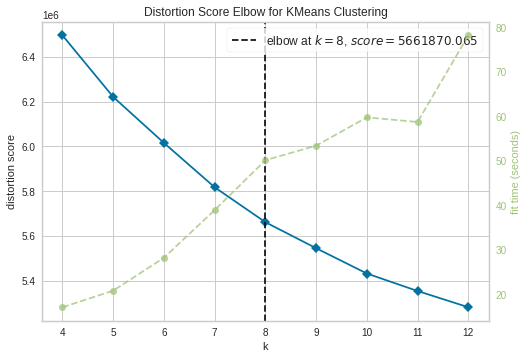

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(X)
visualizer.poof()

Number of Clusters : 6



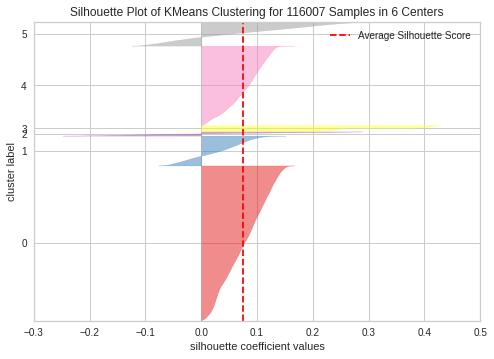

Number of Clusters : 7



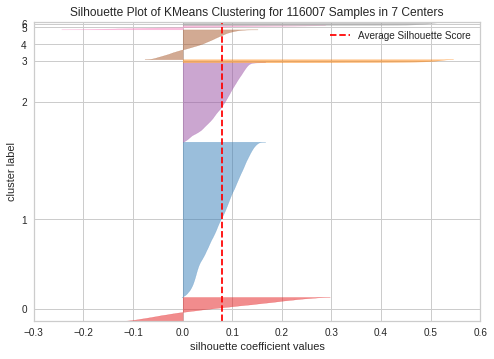

In [60]:
for i in range(6,8):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(X)
    visualizer.poof()

##### With the PCA #####

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(X_pca)
visualizer.poof()

In [ ]:
for i in range(6,8):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(X_pca)
    visualizer.poof()

##### With the SVD #####

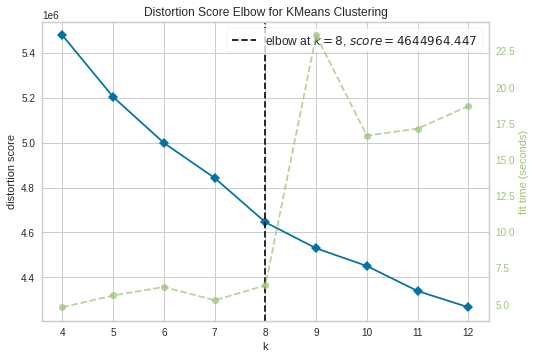

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(X_svd)
visualizer.poof()

Number of Clusters : 6



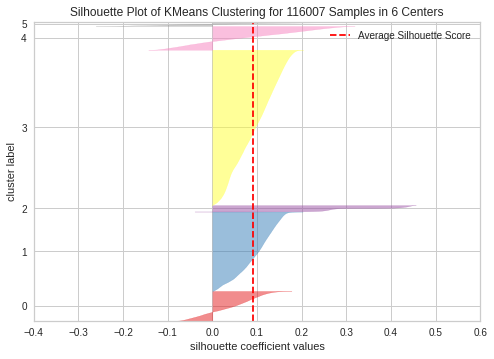

Number of Clusters : 7



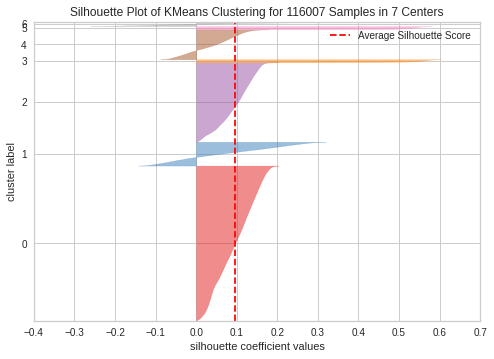

In [58]:
for i in range(6,8):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(X_svd)
    visualizer.poof()

### DBSCAN ###

#### Testing ####

##### Without the PCA #####

In [13]:
# Find the distances to the nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Making a dataframe with its derivatives
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_df = pd.DataFrame()
distances_df['distances'] = distances
for i in range(1, len(distances_df)-1):
    y1 = distances_df.loc[i-1, 'distances']
    y2 = distances_df.loc[i+1, 'distances']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'first_derivative'] = (y2-y1)/(x2-x1)
for i in range(2, len(distances_df)-2):
    y1 = distances_df.loc[i-1, 'first_derivative']
    y2 = distances_df.loc[i+1, 'first_derivative']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'second_derivative'] = (y2-y1)/(x2-x1)

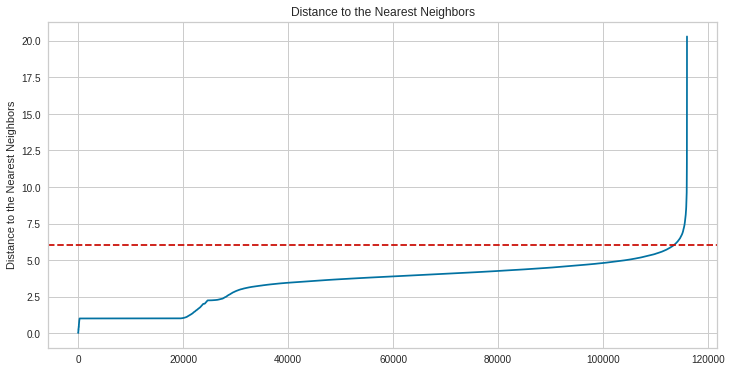

In [24]:
# Best Epsilon
#best_epsilon_line = distances_df[distances_df['second_derivative'] == distances_df['second_derivative'].max()]
#best_epsilon = float(best_epsilon_line['distances'])
#print('The best epsilon value, where the curv is the curve is maximal is :{}\n\n'.format(best_epsilon))

# Ploting
f, ax = plt.subplots(figsize=(12,6))

plt.plot(distances_df['distances'])
plt.axhline(y=6, color='r', linestyle='--')

plt.title('Distance to the Nearest Neighbors')
plt.ylabel('Distance to the Nearest Neighbors')
plt.show()

Estimated number of clusters: 18
Estimated number of noise points: 6764
Silhouette Coefficient: 0.226
Time: 210.715


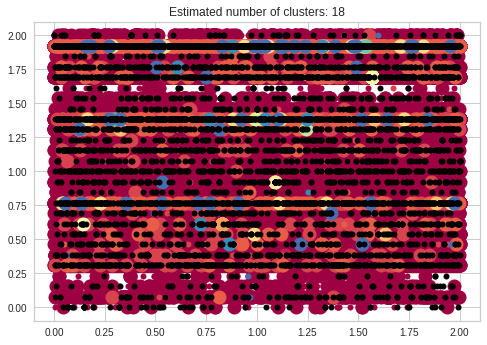

In [19]:
# Compute DBSCAN
t0 = time()
db = DBSCAN(eps=6, min_samples=12, n_jobs = 2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
t1 = time()
elapsed_time = t1 -t0

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Homogeneity: %d' % homogeneity_score(X, labels))
#print('Completeness: %d' % completeness_score(X, labels))
#print('Adjusted Rand Score: %d' % adjusted_rand_score(X, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Time: %0.3f" % elapsed_time)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

##### With the PCA #####

In [25]:
# Find the distances to the nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Making a dataframe with its derivatives
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_df = pd.DataFrame()
distances_df['distances'] = distances
for i in range(1, len(distances_df)-1):
    y1 = distances_df.loc[i-1, 'distances']
    y2 = distances_df.loc[i+1, 'distances']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'first_derivative'] = (y2-y1)/(x2-x1)
for i in range(2, len(distances_df)-2):
    y1 = distances_df.loc[i-1, 'first_derivative']
    y2 = distances_df.loc[i+1, 'first_derivative']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'second_derivative'] = (y2-y1)/(x2-x1)

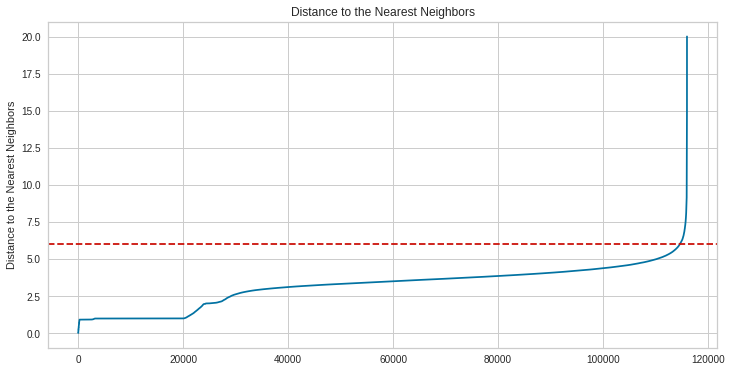

In [26]:
# Best Epsilon
#best_epsilon_line = distances_df[distances_df['second_derivative'] == distances_df['second_derivative'].max()/2]
#best_epsilon = float(best_epsilon_line['distances'])
#print('The best epsilon value, where the curv is the curve is maximal is :{}\n\n'.format(best_epsilon))

# Ploting
f, ax = plt.subplots(figsize=(12,6))

plt.plot(distances_df['distances'])
plt.axhline(y=6, color='r', linestyle='--')

plt.title('Distance to the Nearest Neighbors')
plt.ylabel('Distance to the Nearest Neighbors')
plt.show()

Estimated number of clusters: 18
Estimated number of noise points: 6764
Silhouette Coefficient: 0.226
Time: 213.802


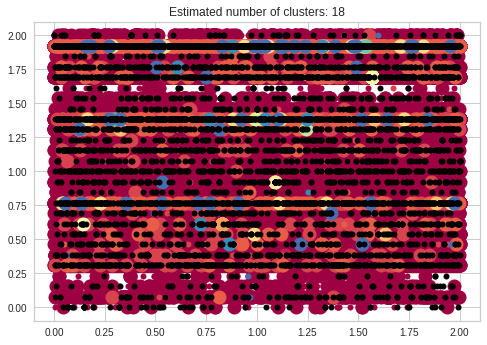

In [28]:
# Compute DBSCAN
t0 = time()
db = DBSCAN(eps=6, min_samples=12, n_jobs = 2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
t1 = time()
elapsed_time = t1 -t0

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Homogeneity: %d' % homogeneity_score(X, labels))
#print('Completeness: %d' % completeness_score(X, labels))
#print('Adjusted Rand Score: %d' % adjusted_rand_score(X, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Time: %0.3f" % elapsed_time)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### OPTICS ###

#### Testing ####

##### Without the PCA #####

In [ ]:
clust = OPTICS(min_samples=12, max_eps=15, cluster_method='dbscan', n_jobs=2)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=12)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1])

# Reachability plot
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

##### With the PCA #####

In [ ]:
clust = OPTICS(min_samples=12, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X_pca)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=12)

space = np.arange(len(X_pca))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1])

# Reachability plot
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_pca[clust.labels_ == -1, 0], X_pca[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

# Refined Data #

## Reducing the Segmented Data ##

We will now look into reducing the data to be able to visualise it and to simplify the segmentation. We will try several methods of reduction to see what work the best.

### PCA ###

We will first try with a PCA since it is one of the most common dimension reduction tool.

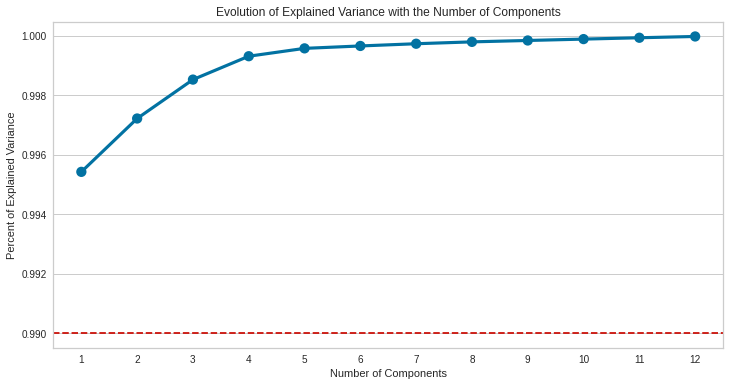

In [13]:
segmented_pca_df = pd.DataFrame(columns=['components_number', 'explained_variance'])

for i in range(1,13):
    segmented_pca_df.loc[i-1, 'components_number'] = i
    segmented_pca = PCA(n_components=i)
    segmented_X_pca = segmented_pca.fit_transform(segmented_X)
    segmented_pca_df.loc[i-1, 'explained_variance'] = segmented_pca.explained_variance_ratio_.sum()

f, ax = plt.subplots(figsize=(12,6))

sns.pointplot(x='components_number', 
              y='explained_variance', 
              data=segmented_pca_df, 
              markers=['o'], 
              linestyles=['-'])

plt.axhline(y=0.99, color='r', linestyle='--')

plt.title('Evolution of Explained Variance with the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Explained Variance')
plt.show()

As we can see, the dataset can be explained even with only one component, which simplifies it a lot.

We will then keep 2 components. (mainly for ease of representation)

In [14]:
segmented_pca = PCA(n_components=2)
segmented_X_pca = segmented_pca.fit_transform(segmented_X)

print('Percentage of variance explained by each component : \n{}\n'.format(segmented_pca.explained_variance_ratio_))
print('Sum of it:\n{}'.format(segmented_pca.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[0.9954217  0.00179569]

Sum of it:
0.9972173887627457


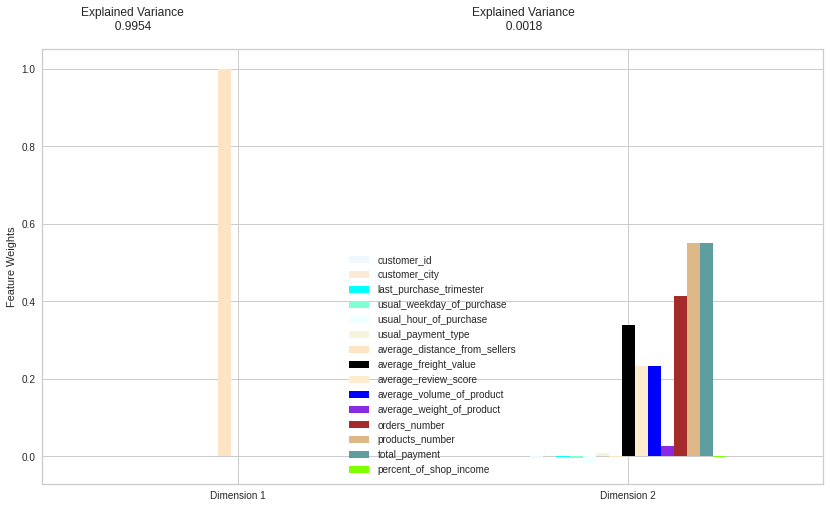

In [15]:
segmented_pca_results = pca_results(segmented_data_df, segmented_pca)

In [16]:
# DataFrame of results
display(segmented_pca_results)

# DataFrame
display(type(segmented_pca_results))

# Cumulative explained variance should add to 1
display(segmented_pca_results['Explained Variance'].cumsum())

,Explained Variance,customer_id,customer_city,last_purchase_trimester,usual_weekday_of_purchase,usual_hour_of_purchase,usual_payment_type,average_distance_from_sellers,average_freight_value,average_review_score,average_volume_of_product,average_weight_of_product,orders_number,products_number,total_payment,percent_of_shop_income
Dimension 1,0.9954,-0.0002,0.0000,0.000,0.0000,-0.0001,-0.0000,1.000,0.0019,0.0000,0.0000,-0.0000,-0.0002,0.0004,0.0004,-0.0000
Dimension 2,0.0018,-0.0030,0.0006,-0.001,-0.0037,-0.0198,0.0083,-0.001,0.3393,0.2332,0.2332,0.0269,0.4139,0.5493,0.5493,-0.0017


pandas.core.frame.DataFrame

Dimension 1    0.9954
Dimension 2    0.9972
Name: Explained Variance, dtype: float64

<AxesSubplot:>

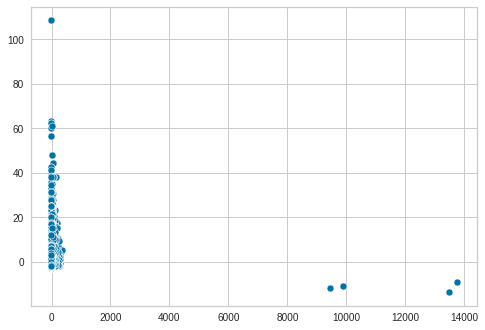

In [15]:
sns.scatterplot(x=segmented_X_pca[:,0], y=segmented_X_pca[:,1])

<AxesSubplot:xlabel='Dim 1', ylabel='Dim 2'>

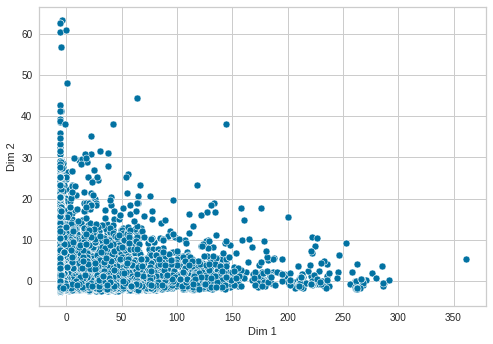

In [42]:
test = pd.DataFrame(segmented_X_pca, columns=['Dim 1', 'Dim 2'])
test = test[test['Dim 1'] < 2000]
test = test[test['Dim 2'] < 80]
sns.scatterplot(x='Dim 1', y='Dim 2', data=test)

### SVD ###

We will first try with a SVD since it is one of the most common dimension reduction tool.

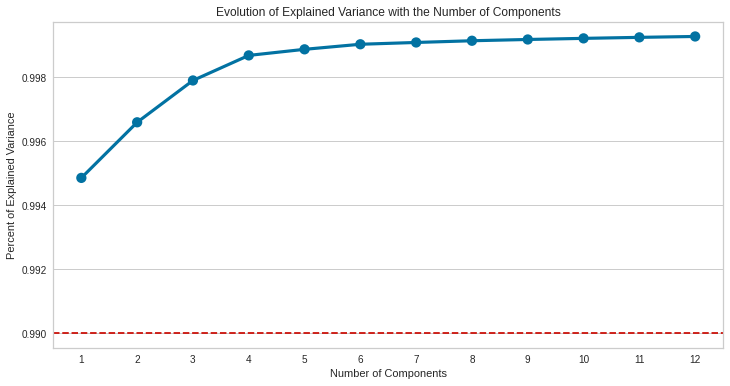

In [37]:
segmented_svd_df = pd.DataFrame(columns=['components_number', 'explained_variance'])

for i in range(1,13):
    segmented_svd_df.loc[i-1, 'components_number'] = i
    segmented_svd = TruncatedSVD(n_components=i)
    segmented_X_svd = segmented_svd.fit_transform(segmented_X)
    segmented_svd_df.loc[i-1, 'explained_variance'] = segmented_svd.explained_variance_ratio_.sum()

f, ax = plt.subplots(figsize=(12,6))

sns.pointplot(x='components_number', 
              y='explained_variance', 
              data=segmented_svd_df, 
              markers=['o'], 
              linestyles=['-'])

plt.axhline(y=0.99, color='r', linestyle='--')

plt.title('Evolution of Explained Variance with the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Explained Variance')
plt.show()

As we can see, the dataset can be explained even with only one component, which simplifies it a lot.

We will then keep 2 components. (mainly for ease of representation)

In [39]:
segmented_svd = TruncatedSVD(n_components=4)
segmented_X_svd = segmented_svd.fit_transform(segmented_X)

print('Percentage of variance explained by each component : \n{}\n'.format(segmented_svd.explained_variance_ratio_))
print('Sum of it:\n{}'.format(segmented_svd.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[9.94849232e-01 1.73830202e-03 1.30798805e-03 7.83441220e-04]

Sum of it:
0.9986789628963478


### MDS and Isomap ###

We tried these method of reduction as well but our dataset was too big and too much RAM was needed for the computer to handle.

### t-SNE ###

In [ ]:
segmented_tsne = TSNE(n_components=2, perplexity=600, n_iter=600, init='pca')
t0 = time()
segmented_X_tsne = segmented_tsne.fit_transform(X)
t1 = time()

In [ ]:
sns.scatterplot(x=segmented_X_tsne[:,0], y=segmented_X_tsne[:,1])

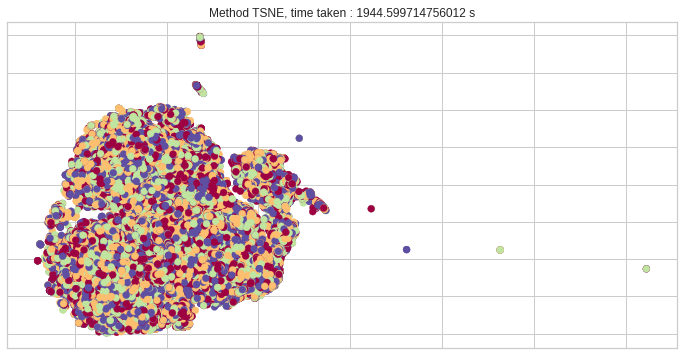

In [34]:
fig, ax = plt.subplots(figsize = (12,6))
colour = np.random.randint(1, 5, size=len(segmented_X_tsne))

ax.scatter(segmented_X_tsne[:, 0], segmented_X_tsne[:, 1], c=colour ,cmap=plt.cm.Spectral)
ax.set_title('Method TSNE, time taken : {} s'.format(t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.show()

## Testing Differents Unsupervised Algorithms ##

### K-Means ###

#### Testing ####

##### Without the PCA #####

In [29]:
cluster_number = [i for i in range(2, 13)]
for number in cluster_number:
    t0 = time()
    clusterer = KMeans(n_clusters=number).fit(segmented_X)
    preds = clusterer.predict(segmented_X)
    t1 = time()
    centers = clusterer.cluster_centers_
    score = silhouette_score(segmented_X, preds, metric='euclidean')
    elapsed_time = t1 - t0
    print('For {} clusters, we have a silhouette score of {} in {} seconds.'.format(number, score, elapsed_time),)

KeyboardInterrupt: 

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,13))

visualizer.fit(segmented_X)
visualizer.poof()

In [ ]:
for i in range(2,9):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(segmented_X)
    visualizer.poof()

##### With the PCA #####

In [30]:
cluster_number = [i for i in range(2, 13)]
for number in cluster_number:
    t0 = time()
    clusterer = KMeans(n_clusters=number).fit(segmented_X_pca)
    preds = clusterer.predict(segmented_X_pca)
    t1 = time()
    centers = clusterer.cluster_centers_
    score = silhouette_score(segmented_X_pca, preds, metric='euclidean')
    elapsed_time = t1 - t0
    print('For {} clusters, we have a silhouette score of {} in {} seconds.'.format(number, score, elapsed_time),)

For 2 clusters, we have a silhouette score of 0.9988632002588511 in 0.6256923675537109 seconds.
For 3 clusters, we have a silhouette score of 0.8859502353917836 in 1.0697762966156006 seconds.
For 4 clusters, we have a silhouette score of 0.8859664138214391 in 1.2902843952178955 seconds.
For 5 clusters, we have a silhouette score of 0.874692563821487 in 1.4278547763824463 seconds.
For 6 clusters, we have a silhouette score of 0.8435174491985711 in 1.5910894870758057 seconds.
For 7 clusters, we have a silhouette score of 0.8346819678081653 in 1.5618817806243896 seconds.
For 8 clusters, we have a silhouette score of 0.7190474704659545 in 1.6118800640106201 seconds.
For 9 clusters, we have a silhouette score of 0.7029846996251438 in 4.59909462928772 seconds.
For 10 clusters, we have a silhouette score of 0.6690128234207208 in 4.481326103210449 seconds.
For 11 clusters, we have a silhouette score of 0.6619779861126959 in 4.528135776519775 seconds.
For 12 clusters, we have a silhouette score

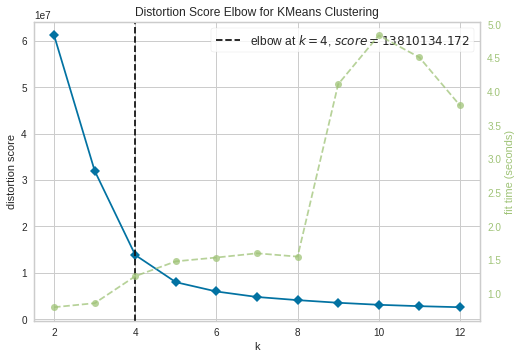

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,13))

visualizer.fit(segmented_X_pca)
visualizer.poof()

Number of Clusters : 2



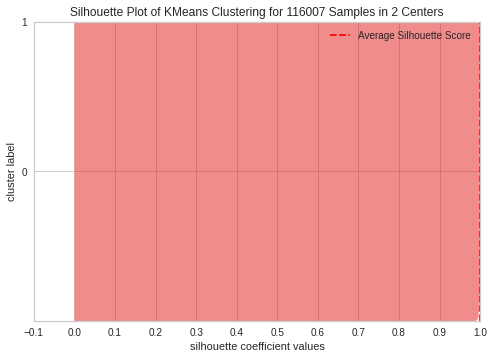

Number of Clusters : 3



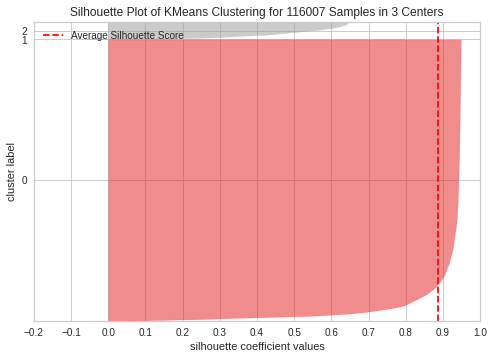

Number of Clusters : 4



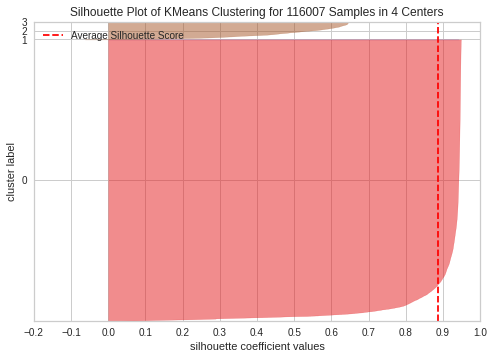

Number of Clusters : 5



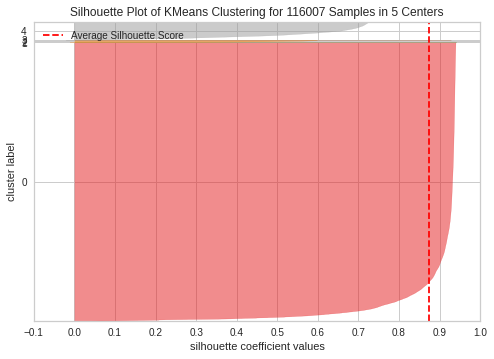

Number of Clusters : 6



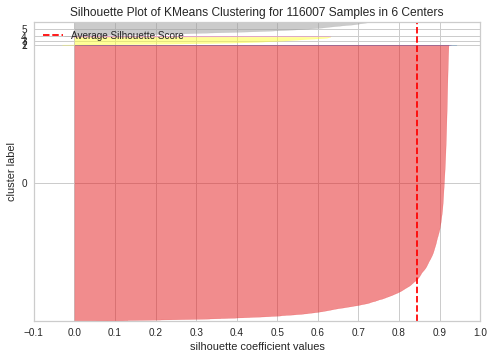

Number of Clusters : 7



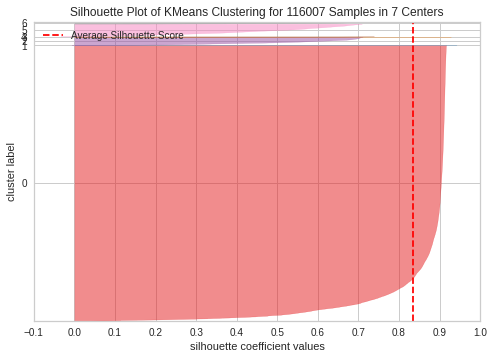

Number of Clusters : 8



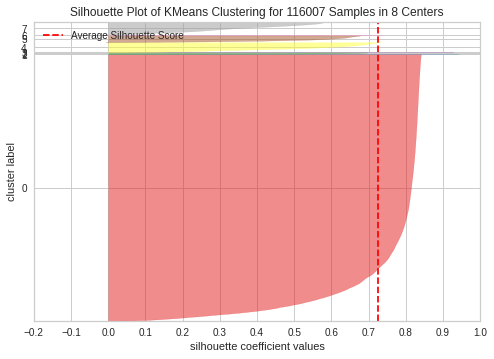

Number of Clusters : 9



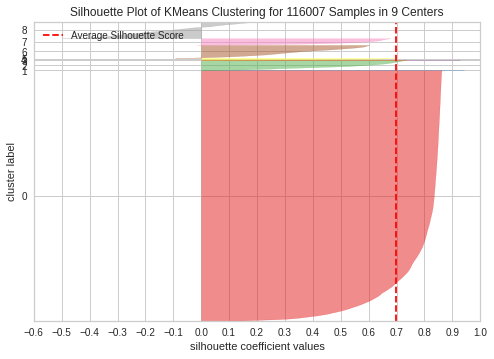

Number of Clusters : 10



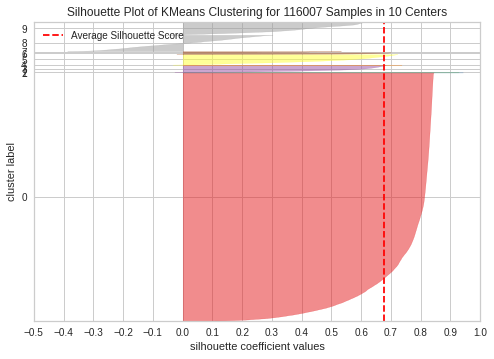

Number of Clusters : 11



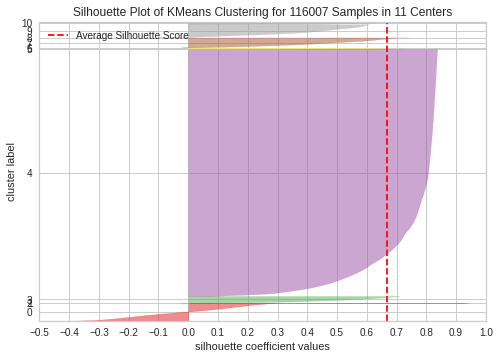

Number of Clusters : 12



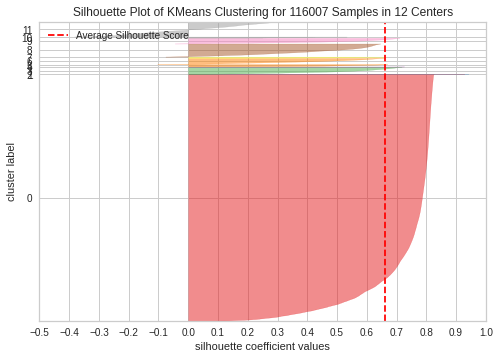

In [32]:
for i in range(2,13):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(segmented_X_pca)
    visualizer.poof()

##### With the SVD #####

In [38]:
cluster_number = [i for i in range(2, 9)]
for number in cluster_number:
    t0 = time()
    clusterer = KMeans(n_clusters=number).fit(segmented_X_svd)
    preds = clusterer.predict(segmented_X_svd)
    t1 = time()
    centers = clusterer.cluster_centers_
    score = silhouette_score(segmented_X_svd, preds, metric='euclidean')
    elapsed_time = t1 - t0
    print('For {} clusters, we have a silhouette score of {} in {} seconds.'.format(number, score, elapsed_time),)

For 2 clusters, we have a silhouette score of 0.998963646323854 in 0.7555363178253174 seconds.
For 3 clusters, we have a silhouette score of 0.902981155863748 in 0.7697498798370361 seconds.
For 4 clusters, we have a silhouette score of 0.9029884914556172 in 1.0957183837890625 seconds.
For 5 clusters, we have a silhouette score of 0.8961481143062275 in 1.1783339977264404 seconds.
For 6 clusters, we have a silhouette score of 0.8726095410256383 in 1.426231861114502 seconds.
For 7 clusters, we have a silhouette score of 0.8658825457102328 in 1.2782502174377441 seconds.
For 8 clusters, we have a silhouette score of 0.7772311865632698 in 1.5235695838928223 seconds.


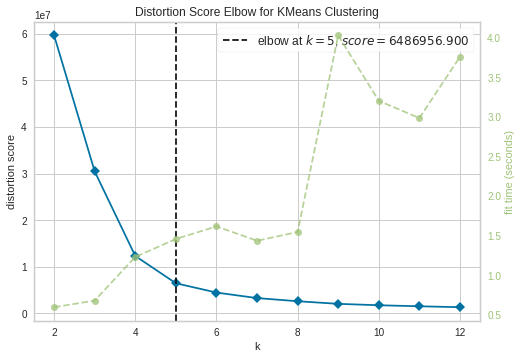

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,13))

visualizer.fit(segmented_X_svd)
visualizer.poof()

Number of Clusters : 2



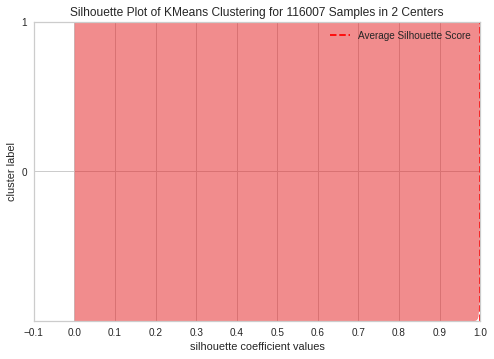

Number of Clusters : 3



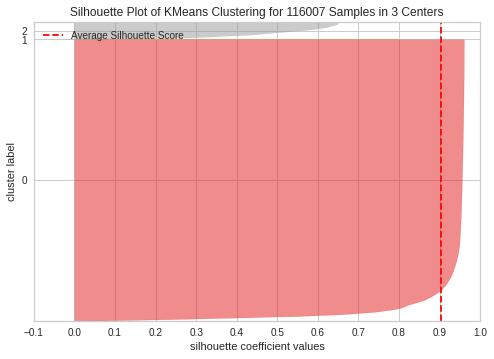

Number of Clusters : 4



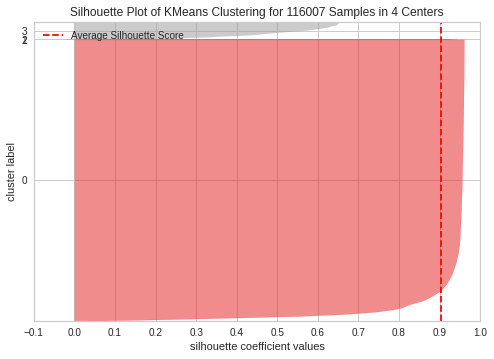

Number of Clusters : 5



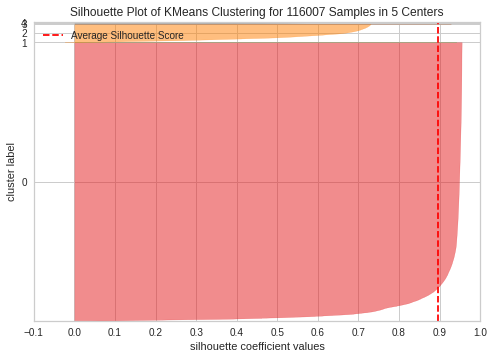

Number of Clusters : 6



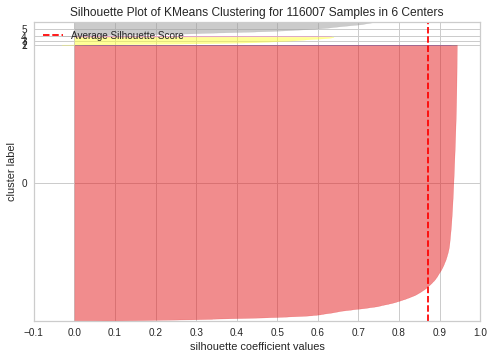

Number of Clusters : 7



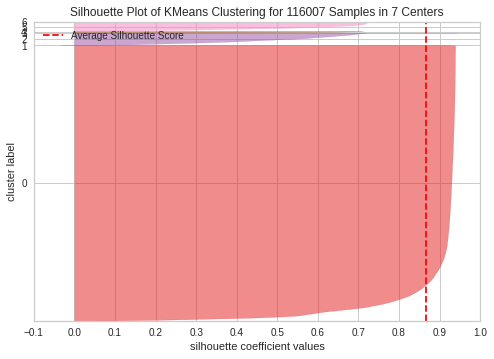

Number of Clusters : 8



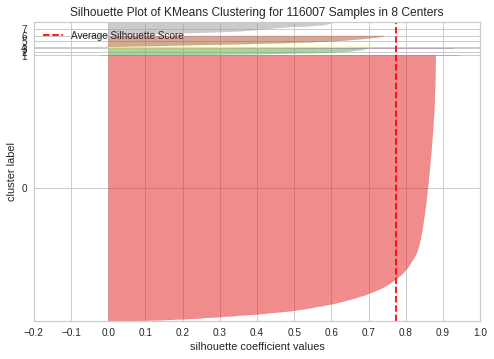

In [37]:
for i in range(2,9):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(segmented_X_svd)
    visualizer.poof()

### DBSCAN ###

#### Testing ####

##### Without the PCA #####

In [28]:
# Find the distances to the nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(segmented_X)
distances, indices = nbrs.kneighbors(segmented_X)

# Making a dataframe with its derivatives
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_df = pd.DataFrame()
distances_df['distances'] = distances
for i in range(1, len(distances_df)-1):
    y1 = distances_df.loc[i-1, 'distances']
    y2 = distances_df.loc[i+1, 'distances']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'first_derivative'] = (y2-y1)/(x2-x1)
for i in range(2, len(distances_df)-2):
    y1 = distances_df.loc[i-1, 'first_derivative']
    y2 = distances_df.loc[i+1, 'first_derivative']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'second_derivative'] = (y2-y1)/(x2-x1)

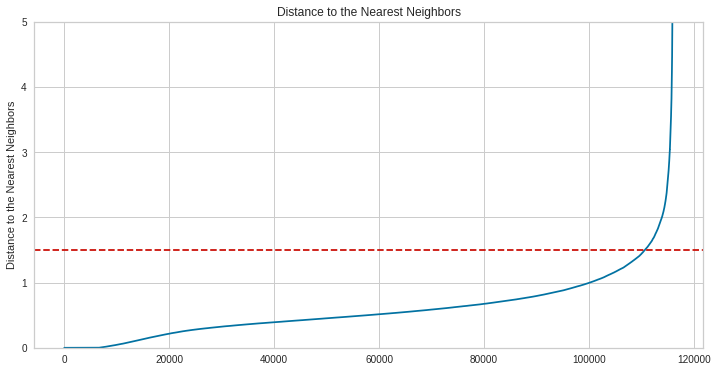

In [34]:
# Best Epsilon
#best_epsilon_line = distances_df[distances_df['second_derivative'] == distances_df['second_derivative'].max()]
#best_epsilon = float(best_epsilon_line['distances'])
#print('The best epsilon value, where the curv is the curve is maximal is :{}\n\n'.format(best_epsilon))

# Ploting
f, ax = plt.subplots(figsize=(12,6))

plt.plot(distances_df['distances'])
plt.axhline(y=1.5, color='r', linestyle='--')

plt.ylim(0,5)
plt.title('Distance to the Nearest Neighbors')
plt.ylabel('Distance to the Nearest Neighbors')
plt.show()

Estimated number of clusters: 2
Estimated number of noise points: 30670
Silhouette Coefficient: 0.520
Time: 129.369


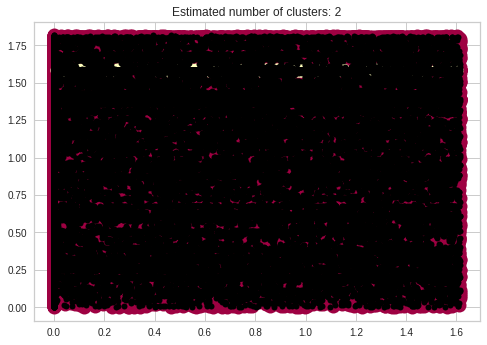

In [40]:
# Compute DBSCAN
t0 = time()
db = DBSCAN(eps=1.5, min_samples=60, n_jobs = 2).fit(segmented_X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
t1 = time()
elapsed_time = t1 -t0

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Homogeneity: %d' % homogeneity_score(X, labels))
#print('Completeness: %d' % completeness_score(X, labels))
#print('Adjusted Rand Score: %d' % adjusted_rand_score(X, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(segmented_X, labels))
print("Time: %0.3f" % elapsed_time)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = segmented_X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = segmented_X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

##### With the PCA #####

In [15]:
# Find the distances to the nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(segmented_X_pca)
distances, indices = nbrs.kneighbors(segmented_X_pca)

# Making a dataframe with its derivatives
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_df = pd.DataFrame()
distances_df['distances'] = distances
for i in range(1, len(distances_df)-1):
    y1 = distances_df.loc[i-1, 'distances']
    y2 = distances_df.loc[i+1, 'distances']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'first_derivative'] = (y2-y1)/(x2-x1)
for i in range(2, len(distances_df)-2):
    y1 = distances_df.loc[i-1, 'first_derivative']
    y2 = distances_df.loc[i+1, 'first_derivative']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'second_derivative'] = (y2-y1)/(x2-x1)

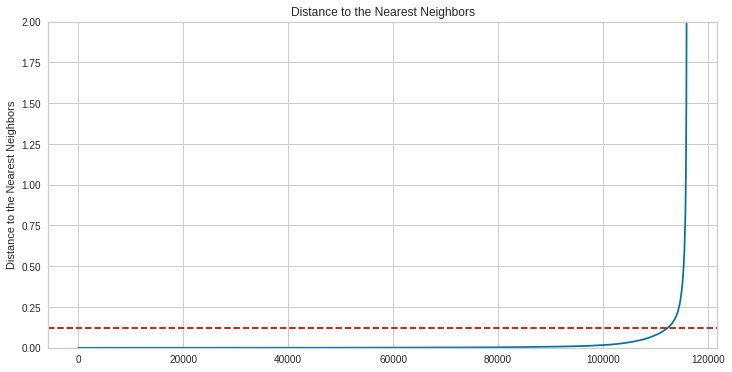

In [26]:
# Best Epsilon
#best_epsilon_line = distances_df[distances_df['second_derivative'] == distances_df['second_derivative'].max()/2]
#best_epsilon = float(best_epsilon_line['distances'])
#print('The best epsilon value, where the curv is the curve is maximal is :{}\n\n'.format(best_epsilon))

# Ploting
f, ax = plt.subplots(figsize=(12,6))

plt.plot(distances_df['distances'])
plt.axhline(y=0.12, color='r', linestyle='--')

plt.ylim(0,2)
plt.title('Distance to the Nearest Neighbors')
plt.ylabel('Distance to the Nearest Neighbors')
plt.show()

Estimated number of clusters: 4
Estimated number of noise points: 24291
Silhouette Coefficient: 0.051
Time: 4.057


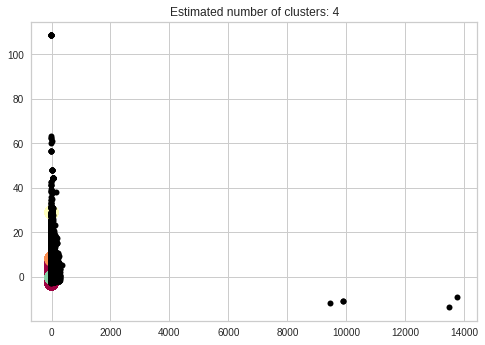

In [41]:
# Compute DBSCAN
t0 = time()
db = DBSCAN(eps=0.12, min_samples=60, n_jobs = 2).fit(segmented_X_pca)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
t1 = time()
elapsed_time = t1 -t0

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Homogeneity: %d' % homogeneity_score(X, labels))
#print('Completeness: %d' % completeness_score(X, labels))
#print('Adjusted Rand Score: %d' % adjusted_rand_score(X, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(segmented_X_pca, labels))
print("Time: %0.3f" % elapsed_time)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = segmented_X_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = segmented_X_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.xlim(-36,1000)
plt.ylim(-5,80)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### OPTICS ###

#### Testing ####

##### Without the PCA #####

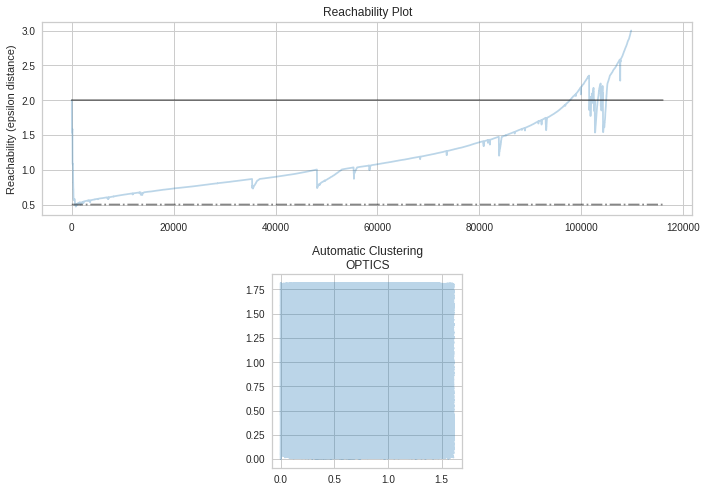

In [44]:
clust = OPTICS(min_samples=60, max_eps=3, cluster_method='dbscan', n_jobs=2)

# Run the fit
clust.fit(segmented_X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=12)

space = np.arange(len(segmented_X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1])

# Reachability plot
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = segmented_X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(segmented_X[clust.labels_ == -1, 0], segmented_X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

##### With the PCA #####

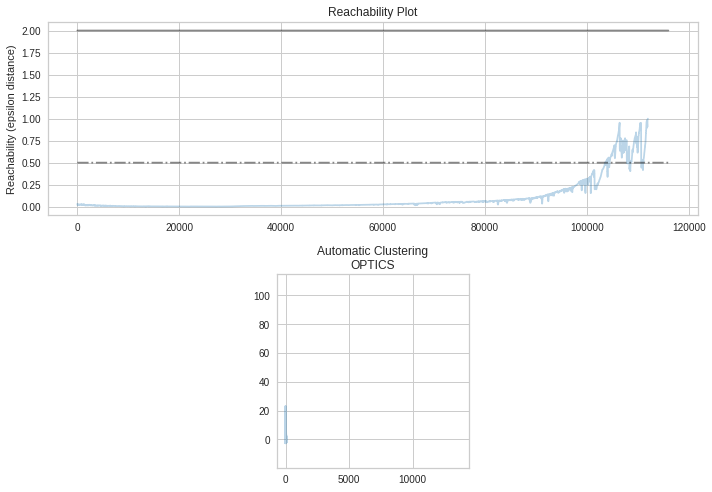

In [45]:
clust = OPTICS(min_samples=60, max_eps=1, cluster_method='dbscan', n_jobs=2)

# Run the fit
clust.fit(segmented_X_pca)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=12)

space = np.arange(len(segmented_X_pca))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1])

# Reachability plot
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = segmented_X_pca[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(segmented_X_pca[clust.labels_ == -1, 0], segmented_X_pca[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

### Gaussian Mixture ###

#### Testing ####

##### Without the PCA #####

##### With the PCA #####

## Creating and Evaluating the Model ##

We have a silhouette score of 0.8961759694123559 in 1.4588723182678223 seconds. The silhouettes look like :


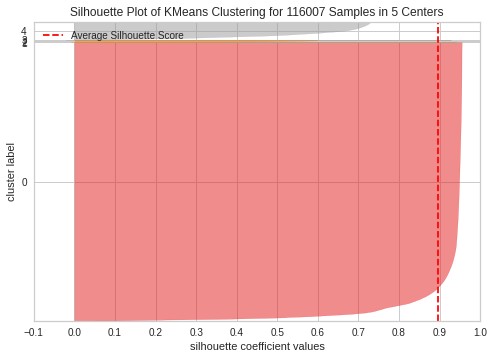

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 116007 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
# We will chose 4 clusters with the Reduced Data 

t0 = time()
clusterer = KMeans(n_clusters=5).fit(segmented_X_pca)
preds = clusterer.predict(segmented_X_pca)
t1 = time()
centers = clusterer.cluster_centers_
score = silhouette_score(segmented_X_pca, preds, metric='euclidean')
elapsed_time = t1 - t0

print('We have a silhouette score of {} in {} seconds.'.format(score,
                                                               elapsed_time),
     'The silhouettes look like :')

model = KMeans(5)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(segmented_X_pca)
visualizer.poof()

The clusters looks like that:


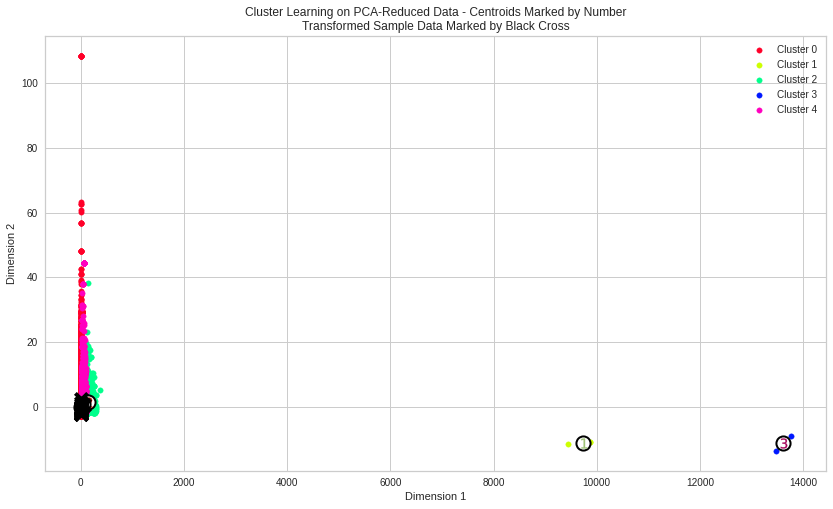

In [19]:
print('The clusters looks like that:')

indices_list = np.random.randint(low=0, high=len(segmented_data_df), size=24)
samples = pd.DataFrame(segmented_data_df.loc[indices_list], 
                       columns=segmented_data_df.columns
                      ).reset_index(drop=True)

samples_X = segmented_preprocessing.fit_transform(samples)
pca_samples = segmented_pca.transform(samples_X)
reduced_data_df = pd.DataFrame(segmented_X_pca, columns = ['Dimension 1', 'Dimension 2'])

cluster_results(reduced_data_df, preds, centers, pca_samples)

In [20]:
true_centers = segmented_pca.inverse_transform(centers)
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers_df = pd.DataFrame(np.round(true_centers), columns = segmented_data_df.columns)
true_centers_df.index = segments
display(true_centers_df)

,customer_id,customer_city,last_purchase_trimester,usual_weekday_of_purchase,usual_hour_of_purchase,usual_payment_type,average_distance_from_sellers,average_freight_value,average_review_score,average_volume_of_product,average_weight_of_product,orders_number,products_number,total_payment,percent_of_shop_income
Segment 0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
Segment 1,-0.0,1.0,1.0,2.0,1.0,1.0,9731.0,15.0,-2.0,-2.0,-0.0,-6.0,-1.0,-1.0,0.0
Segment 2,1.0,1.0,1.0,2.0,1.0,1.0,146.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Segment 3,-1.0,1.0,1.0,2.0,1.0,1.0,13620.0,23.0,-2.0,-2.0,-0.0,-7.0,0.0,0.0,0.0
Segment 4,1.0,1.0,1.0,2.0,1.0,1.0,54.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [21]:
display(true_centers_df - segmented_data_df.median())

,average_distance_from_sellers,average_freight_value,average_review_score,average_volume_of_product,average_weight_of_product,customer_city,customer_id,last_purchase_trimester,orders_number,percent_of_shop_income,products_number,total_payment,usual_hour_of_purchase,usual_payment_type,usual_weekday_of_purchase
Segment 0,-284.356251,-16.35,-4.0,-6929.0,-6930.0,NaN,NaN,NaN,0.0,0.999248,-1.0,-115.03,-14.0,NaN,NaN
Segment 1,9445.643749,-1.35,-7.0,-6932.0,-6930.0,NaN,NaN,NaN,-7.0,-0.000752,-2.0,-116.03,-14.0,NaN,NaN
Segment 2,-139.356251,-15.35,-4.0,-6929.0,-6930.0,NaN,NaN,NaN,0.0,0.999248,0.0,-114.03,-14.0,NaN,NaN
Segment 3,13334.643749,6.65,-7.0,-6932.0,-6930.0,NaN,NaN,NaN,-8.0,-0.000752,-1.0,-115.03,-14.0,NaN,NaN
Segment 4,-231.356251,-15.35,-4.0,-6929.0,-6930.0,NaN,NaN,NaN,0.0,0.999248,0.0,-114.03,-14.0,NaN,NaN


In [22]:
display(true_centers_df - segmented_data_df.mean())

,average_distance_from_sellers,average_freight_value,average_review_score,average_volume_of_product,average_weight_of_product,customer_city,customer_id,last_purchase_trimester,orders_number,percent_of_shop_income,products_number,total_payment,usual_hour_of_purchase,usual_payment_type,usual_weekday_of_purchase
Segment 0,-17589.856295,-20.055148,-3.018535,-15438.823837,-15439.823837,NaN,NaN,NaN,-0.087598,0.998782,-1.823468,-186.470958,-13.707138,NaN,NaN
Segment 1,-7859.856295,-5.055148,-6.018535,-15441.823837,-15439.823837,NaN,NaN,NaN,-7.087598,-0.001218,-2.823468,-187.470958,-13.707138,NaN,NaN
Segment 2,-17444.856295,-19.055148,-3.018535,-15438.823837,-15439.823837,NaN,NaN,NaN,-0.087598,0.998782,-0.823468,-185.470958,-13.707138,NaN,NaN
Segment 3,-3970.856295,2.944852,-6.018535,-15441.823837,-15439.823837,NaN,NaN,NaN,-8.087598,-0.001218,-1.823468,-186.470958,-13.707138,NaN,NaN
Segment 4,-17536.856295,-19.055148,-3.018535,-15438.823837,-15439.823837,NaN,NaN,NaN,-0.087598,0.998782,-0.823468,-185.470958,-13.707138,NaN,NaN
